In [1]:
import matplotlib.patches as patches
import Metrica_Viz as mviz
import Metrica_IO as mio
import numpy as np
import pandas as pd
from typing import List
from cmap import Colormap
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering, BisectingKMeans, KMeans, SpectralClustering
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import euclidean_distances

In [2]:
df = pd.read_csv("Sample_Game_2_RawTrackingData_Home_Team.csv")

C:\Users\noill\AppData\Local\Temp\ipykernel_18108\3567387257.py:1: DtypeWarning: Columns (0,1,2,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Sample_Game_2_RawTrackingData_Home_Team.csv")


In [3]:
df = df.iloc[2:].reset_index()
df = df.drop(columns=["index"])
ball_x = df["Unnamed: 31"]
ball_y = df["Unnamed: 32"]
columns_to_drop = df.columns[df.iloc[0].isna()]
df = df.drop(columns=columns_to_drop)

In [4]:
df.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Home,Unnamed: 4,Home.1,Unnamed: 6,Home.2,Unnamed: 8,Home.3,...,Home.6,Unnamed: 16,Home.7,Unnamed: 18,Home.8,Unnamed: 20,Home.9,Unnamed: 22,Home.10,Unnamed: 24
0,1,1,0.04,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.58508,0.53017,0.53163,0.75084,0.50637,0.30137,0.50194,0.61123,0.94275,0.50413
1,1,2,0.08,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.58508,0.53017,0.53163,0.75084,0.50637,0.30137,0.50194,0.61123,0.94275,0.50413
2,1,3,0.12,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.58508,0.53017,0.53163,0.75084,0.50637,0.30137,0.50194,0.61123,0.94275,0.50413
3,1,4,0.16,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.58508,0.53017,0.53163,0.75084,0.50637,0.30137,0.50194,0.61123,0.94275,0.50413
4,1,5,0.2,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.58508,0.53017,0.53163,0.75084,0.50637,0.30137,0.50194,0.61123,0.94275,0.50413


In [5]:
head = "P_1-x"
headers = [head]

count = 1
for i in range(4, df.shape[1]):
    if "x" in headers[count-1]:
        head = f"P_{(count//2)+1}-y"
    else:
        head = f"P_{(count//2)+1}-x"
    headers.append(head)
    count += 1
    
headers = ["Period", "Frame", "Time[s]"] + headers
df.columns = headers

In [6]:
df.head()

,Period,Frame,Time[s],P_1-x,P_1-y,P_2-x,P_2-y,P_3-x,P_3-y,P_4-x,...,P_7-x,P_7-y,P_8-x,P_8-y,P_9-x,P_9-y,P_10-x,P_10-y,P_11-x,P_11-y
0,1,1,0.04,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.58508,0.53017,0.53163,0.75084,0.50637,0.30137,0.50194,0.61123,0.94275,0.50413
1,1,2,0.08,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.58508,0.53017,0.53163,0.75084,0.50637,0.30137,0.50194,0.61123,0.94275,0.50413
2,1,3,0.12,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.58508,0.53017,0.53163,0.75084,0.50637,0.30137,0.50194,0.61123,0.94275,0.50413
3,1,4,0.16,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.58508,0.53017,0.53163,0.75084,0.50637,0.30137,0.50194,0.61123,0.94275,0.50413
4,1,5,0.2,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.58508,0.53017,0.53163,0.75084,0.50637,0.30137,0.50194,0.61123,0.94275,0.50413


In [7]:
df.tail()

,Period,Frame,Time[s],P_1-x,P_1-y,P_2-x,P_2-y,P_3-x,P_3-y,P_4-x,...,P_7-x,P_7-y,P_8-x,P_8-y,P_9-x,P_9-y,P_10-x,P_10-y,P_11-x,P_11-y
141151,2,141152,5646.08,0.38499,0.15356,0.22558,0.41355,0.27142,0.32209,NaN,...,0.36216,0.56218,NaN,NaN,0.28426,0.35845,NaN,NaN,0.06285,0.51243
141152,2,141153,5646.12,0.38499,0.15356,0.22558,0.41355,0.27142,0.32209,NaN,...,0.36216,0.56218,NaN,NaN,0.28365,0.35933,NaN,NaN,0.06285,0.51243
141153,2,141154,5646.16,0.38499,0.15356,0.22558,0.41355,0.27142,0.32209,NaN,...,0.36216,0.56218,NaN,NaN,0.28322,0.36067,NaN,NaN,0.06285,0.51243
141154,2,141155,5646.2,0.38499,0.15356,0.22558,0.41355,0.27142,0.32209,NaN,...,0.36216,0.56218,NaN,NaN,0.28266,0.36095,NaN,NaN,0.06285,0.51243
141155,2,141156,5646.24,0.38499,0.15356,0.22558,0.41355,0.27142,0.32209,NaN,...,0.36216,0.56218,NaN,NaN,0.28201,0.36123,NaN,NaN,0.06285,0.51243


## You'll see the data goes from 0 to 1 on each axis. The coordiante (0,0) is the top left, (1,1) is the bottom right, and (0.5,0.5) is the kick off point.

In [8]:
df['Period'] = pd.to_numeric(df['Period'], errors='coerce')
df["ball-x"], df["ball-y"] = ball_x, ball_y
period_1_data = df[df["Period"] == 1]
period_1_data = period_1_data[50:]

In [9]:
period_1_data

,Period,Frame,Time[s],P_1-x,P_1-y,P_2-x,P_2-y,P_3-x,P_3-y,P_4-x,...,P_8-x,P_8-y,P_9-x,P_9-y,P_10-x,P_10-y,P_11-x,P_11-y,ball-x,ball-y
50,1,51,2.04,0.64787,0.27031,0.67763,0.42630,0.68143,0.54622,0.64436,...,0.53316,0.78648,0.5014,0.35295,0.50046,0.65322,0.94791,0.48986,0.50216,0.50376
51,1,52,2.08,0.64797,0.27005,0.67765,0.42629,0.68101,0.54602,0.64428,...,0.53323,0.78651,0.50128,0.35261,0.50036,0.65297,0.94779,0.49005,0.5004,0.50384
52,1,53,2.12,0.64805,0.26978,0.67767,0.42637,0.6806,0.54582,0.64418,...,0.53328,0.78657,0.50115,0.35226,0.50025,0.65270,0.94766,0.49025,0.4977,0.50397
53,1,54,2.16,0.64815,0.26943,0.67769,0.42634,0.6802,0.54562,0.64409,...,0.53334,0.78658,0.50102,0.35198,0.50011,0.65247,0.94756,0.49039,0.495,0.50410
54,1,55,2.2,0.64826,0.26908,0.6777,0.42630,0.67978,0.54545,0.64398,...,0.53341,0.78658,0.50088,0.35169,0.49994,0.65213,0.94746,0.49049,0.4923,0.50422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67936,1,67937,2717.48,0.51337,0.71683,0.52318,0.78966,0.54702,0.86195,0.51242,...,0.40066,0.50905,0.35073,0.59980,0.337,0.79222,0.81546,0.72958,NaN,NaN
67937,1,67938,2717.52,0.51339,0.71801,0.52312,0.79035,0.54692,0.86271,0.51242,...,0.40095,0.50993,0.35105,0.60026,0.33727,0.79263,0.81461,0.73064,NaN,NaN
67938,1,67939,2717.56,0.5134,0.71929,0.52312,0.79124,0.54677,0.86355,0.51242,...,0.40122,0.51062,0.35136,0.60081,0.33756,0.79303,0.81413,0.73124,NaN,NaN
67939,1,67940,2717.6,0.51342,0.72035,0.52315,0.79171,0.54673,0.86423,0.51242,...,0.40148,0.51078,0.35166,0.60165,0.33781,0.79344,0.81385,0.73124,NaN,NaN


In [10]:
period_1_data.iloc[0].iloc[3]

'0.64787'

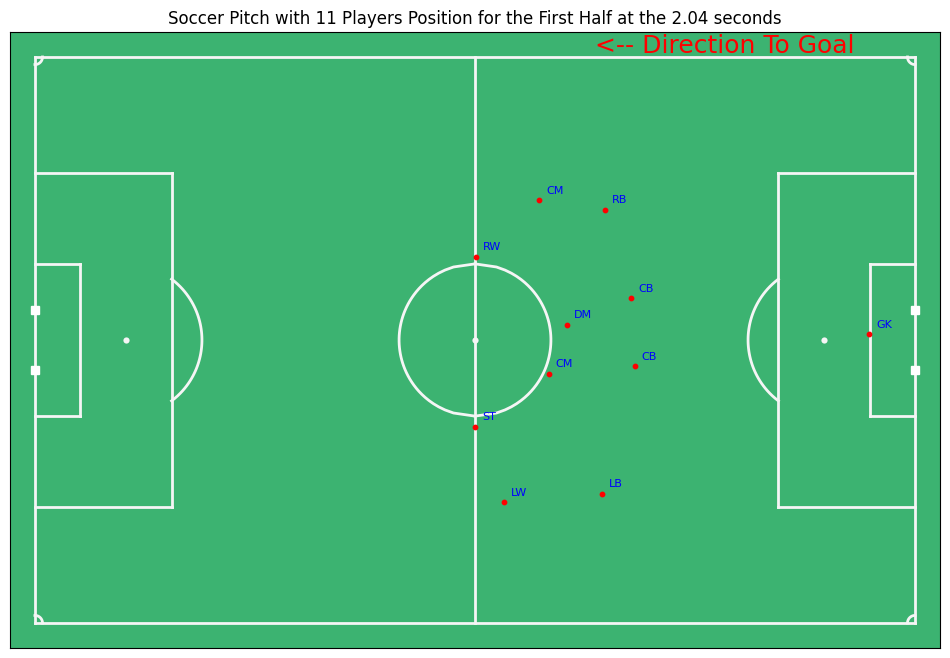

In [11]:
fig, ax = mviz.plot_pitch()

# Prepare player positions and their coordinates on the pitch
frame = period_1_data.iloc[0]
pos_x = [[float(frame.iloc[i]), period_1_data.columns[i]] for i in range(3, period_1_data.shape[1]) if "-x" in period_1_data.columns[i]]
pos_y = [[float(frame.iloc[i]), period_1_data.columns[i]] for i in range(3, period_1_data.shape[1]) if "-y" in period_1_data.columns[i]]

data_x, col_x = [item[0] for item in pos_x], [item[1] for item in pos_x]
data_y, col_y = [item[0] for item in pos_y], [item[1] for item in pos_y]

positions_x = pd.DataFrame([data_x], columns=col_x)
positions_y = pd.DataFrame([data_y], columns=col_y)

# # Changing the dataset to meter or pitch coordinates
positions_x = mio.to_metric_coordinates(positions_x)
positions_y = mio.to_metric_coordinates(positions_y)
player_pos = ["RB", "CB", "CB", "LB", "CM", "DM", "CM", "LW", "RW", "ST", "GK"]
MEAN_X_POS = positions_x.mean(axis=1)[0]
DIRECTION_TO_GOAL = "<--" if MEAN_X_POS > 0 else "-->"
DIRECTION_TO_GOAL += " Direction To Goal"

# Annotate player names
for i, (x, y, name) in enumerate(zip(positions_x.iloc[0], positions_y.iloc[0], player_pos)):
    ax.scatter(x, y, color="red", s=10, zorder=2)  # Plot red dot
    ax.annotate(name, (x, y), xytext=(5, 5), textcoords="offset points", fontsize=8, color='blue')
ax.annotate(DIRECTION_TO_GOAL, (MEAN_X_POS, 29.55), xytext=(MEAN_X_POS, 29.55), textcoords="offset points", fontsize=18, color="red")

seconds = frame.iloc[2]
plt.title(f"Soccer Pitch with 11 Players Position for the First Half at the {seconds} seconds")
plt.show()

In [12]:
period_1_data

,Period,Frame,Time[s],P_1-x,P_1-y,P_2-x,P_2-y,P_3-x,P_3-y,P_4-x,...,P_8-x,P_8-y,P_9-x,P_9-y,P_10-x,P_10-y,P_11-x,P_11-y,ball-x,ball-y
50,1,51,2.04,0.64787,0.27031,0.67763,0.42630,0.68143,0.54622,0.64436,...,0.53316,0.78648,0.5014,0.35295,0.50046,0.65322,0.94791,0.48986,0.50216,0.50376
51,1,52,2.08,0.64797,0.27005,0.67765,0.42629,0.68101,0.54602,0.64428,...,0.53323,0.78651,0.50128,0.35261,0.50036,0.65297,0.94779,0.49005,0.5004,0.50384
52,1,53,2.12,0.64805,0.26978,0.67767,0.42637,0.6806,0.54582,0.64418,...,0.53328,0.78657,0.50115,0.35226,0.50025,0.65270,0.94766,0.49025,0.4977,0.50397
53,1,54,2.16,0.64815,0.26943,0.67769,0.42634,0.6802,0.54562,0.64409,...,0.53334,0.78658,0.50102,0.35198,0.50011,0.65247,0.94756,0.49039,0.495,0.50410
54,1,55,2.2,0.64826,0.26908,0.6777,0.42630,0.67978,0.54545,0.64398,...,0.53341,0.78658,0.50088,0.35169,0.49994,0.65213,0.94746,0.49049,0.4923,0.50422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67936,1,67937,2717.48,0.51337,0.71683,0.52318,0.78966,0.54702,0.86195,0.51242,...,0.40066,0.50905,0.35073,0.59980,0.337,0.79222,0.81546,0.72958,NaN,NaN
67937,1,67938,2717.52,0.51339,0.71801,0.52312,0.79035,0.54692,0.86271,0.51242,...,0.40095,0.50993,0.35105,0.60026,0.33727,0.79263,0.81461,0.73064,NaN,NaN
67938,1,67939,2717.56,0.5134,0.71929,0.52312,0.79124,0.54677,0.86355,0.51242,...,0.40122,0.51062,0.35136,0.60081,0.33756,0.79303,0.81413,0.73124,NaN,NaN
67939,1,67940,2717.6,0.51342,0.72035,0.52315,0.79171,0.54673,0.86423,0.51242,...,0.40148,0.51078,0.35166,0.60165,0.33781,0.79344,0.81385,0.73124,NaN,NaN


## Tracking for individual Players for the First Period

In [13]:
period_1_data = period_1_data[50:25000]

In [14]:
period_1_data

,Period,Frame,Time[s],P_1-x,P_1-y,P_2-x,P_2-y,P_3-x,P_3-y,P_4-x,...,P_8-x,P_8-y,P_9-x,P_9-y,P_10-x,P_10-y,P_11-x,P_11-y,ball-x,ball-y
100,1,101,4.04,0.65068,0.27656,0.67446,0.42416,0.66007,0.55359,0.64281,...,0.53035,0.78457,0.48183,0.38099,0.46751,0.60512,0.93882,0.49130,0.40757,0.50871
101,1,102,4.08,0.65064,0.27715,0.67451,0.42399,0.65974,0.55393,0.64301,...,0.53024,0.78437,0.48137,0.38260,0.46653,0.60325,0.93846,0.49140,0.40796,0.50877
102,1,103,4.12,0.65062,0.27774,0.67457,0.42388,0.65942,0.55426,0.64322,...,0.53015,0.78412,0.48092,0.38420,0.46557,0.60136,0.93809,0.49150,0.40835,0.50882
103,1,104,4.16,0.65061,0.27824,0.67466,0.42376,0.65913,0.55452,0.64343,...,0.53006,0.78383,0.48049,0.38572,0.46462,0.59946,0.93775,0.49154,0.40876,0.50892
104,1,105,4.2,0.6506,0.27882,0.67477,0.42364,0.65885,0.55478,0.64366,...,0.52999,0.78353,0.48009,0.38730,0.46369,0.59749,0.93742,0.49154,0.40917,0.50901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25045,1,25046,1001.84,0.86968,0.38248,0.85202,0.45872,0.84975,0.57003,0.79781,...,0.80781,0.60322,0.74916,0.62993,0.58984,0.47618,0.96054,0.52040,0.79919,0.69861
25046,1,25047,1001.88,0.86968,0.38333,0.85172,0.45923,0.84967,0.57131,0.79638,...,0.80791,0.60402,0.74786,0.63118,0.58966,0.47677,0.96018,0.52059,0.79778,0.69844
25047,1,25048,1001.92,0.86966,0.38414,0.85136,0.45978,0.84961,0.57251,0.79492,...,0.80798,0.60480,0.74648,0.63245,0.58947,0.47734,0.95983,0.52078,0.79634,0.69825
25048,1,25049,1001.96,0.86964,0.38486,0.85098,0.46031,0.84953,0.57371,0.79344,...,0.80801,0.60569,0.74507,0.63363,0.58926,0.47790,0.95947,0.52092,0.79488,0.69805


In [15]:
def player_tracking(dataset: pd.DataFrame, players: List[int] = [11], markersize: int = 1) -> None:
    fig, ax = mviz.plot_pitch()
    color_map = Colormap('tol:rainbow_discrete_3')

    ball_is_there = False
    for i, player in enumerate(players):
        x = f"P_{player}-x"
        y = f"P_{player}-y"
    
        # Prepare player positions and their coordinates on the pitch
        data_x = pd.to_numeric(dataset[x], errors='coerce')
        data_y = pd.to_numeric(dataset[y], errors='coerce')

        # Ball positions
        ba_x = pd.to_numeric(dataset["ball-x"], errors='coerce')
        ba_y = pd.to_numeric(dataset["ball-y"], errors='coerce')
        
        # Create DataFrames with a single column for x and y coordinate of a player
        positions_x = pd.DataFrame(data_x, columns=[x])
        positions_y = pd.DataFrame(data_y, columns=[y])

        ba_x = pd.DataFrame(ba_x, columns=["ball-x"])
        ba_y = pd.DataFrame(ba_y, columns=["ball-y"])

        # Changing the dataset to metric or pitch coordinates
        positions_x = mio.to_metric_coordinates(positions_x)
        positions_y = mio.to_metric_coordinates(positions_y)
        ba_x = mio.to_metric_coordinates(ba_x)
        ba_y = mio.to_metric_coordinates(ba_y)

        player_pos = ["RB", "CB", "CB", "LB", "CM", "DM", "CM", "LW", "RW", "ST", "GK"]
        
        color = color_map(i / len(players))

        ax.plot(positions_x[x], positions_y[y], marker=".", markersize=markersize, color=color, label=f"Player {player} ({player_pos[player-1]})")  # Plot players
        ax.annotate("Initial Point", (positions_x[x].iloc[0], positions_y[y].iloc[0]), xytext=(5, 5), textcoords="offset points", fontsize=8, color=color)
        # ax.annotate(player_pos[player-1], (x, y), xytext=(5, 5), textcoords="offset points", fontsize=8, color='blue')    
        
        if not ball_is_there:
            ax.plot(ba_x["ball-x"], ba_y["ball-y"], marker=".", markersize=int(markersize * 1.5), color="black", zorder=2, label="Ball")
            ax.annotate("Initial Point", (ba_x["ball-x"].iloc[0], ba_y["ball-y"].iloc[0]), xytext=(5, 5), textcoords="offset points", fontsize=8, color="black")
            ax.annotate(DIRECTION_TO_GOAL, (MEAN_X_POS, 29.55), xytext=(MEAN_X_POS, 29.55), textcoords="offset points", fontsize=18, color="red")
        ball_is_there = True
    
    start_seconds = dataset["Time[s]"].iloc[0]
    end_seconds = dataset["Time[s]"].iloc[-1]
    pl = [i for i in players]
    
    ax.set_title(f"Tracking for Player {pl} in the First Half from {start_seconds} seconds to {int(end_seconds) // 60} minutes")
    ax.legend(title="Player and Ball colors", loc='upper left', fontsize=8)
    
    plt.show()

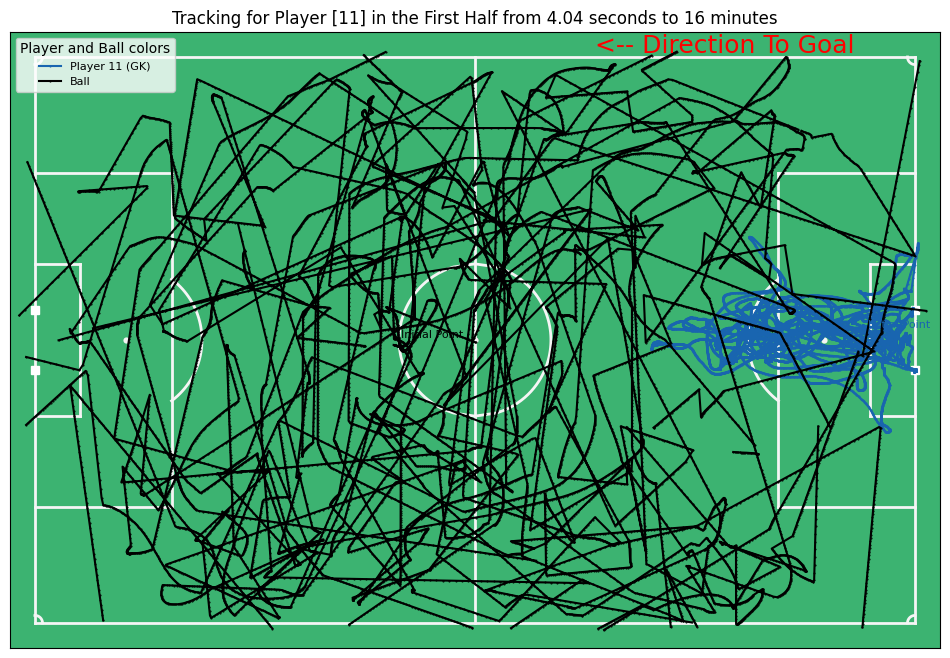

In [16]:
player_tracking(period_1_data)

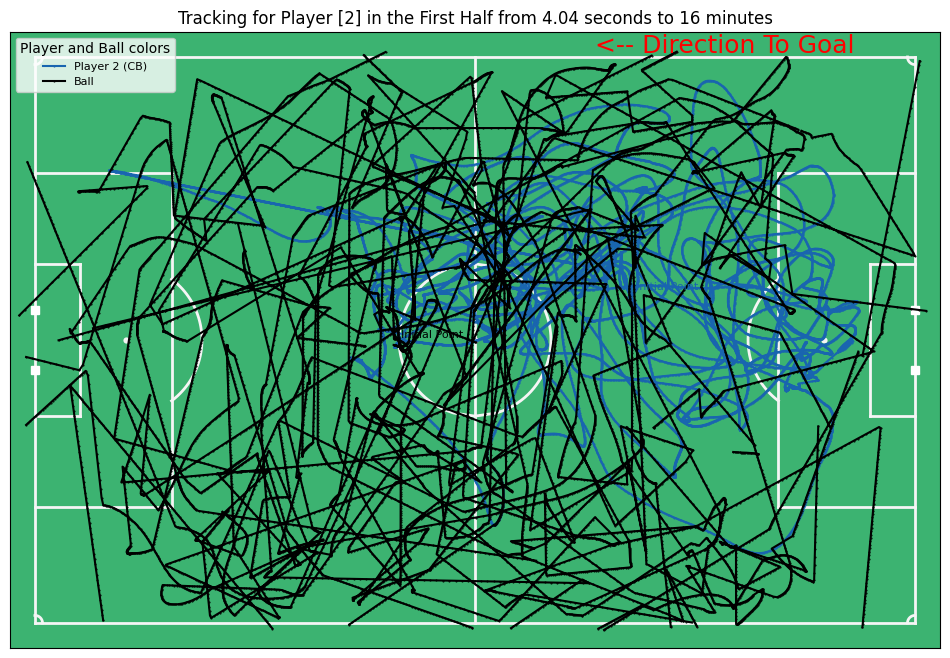

In [17]:
player_tracking(period_1_data, [2])

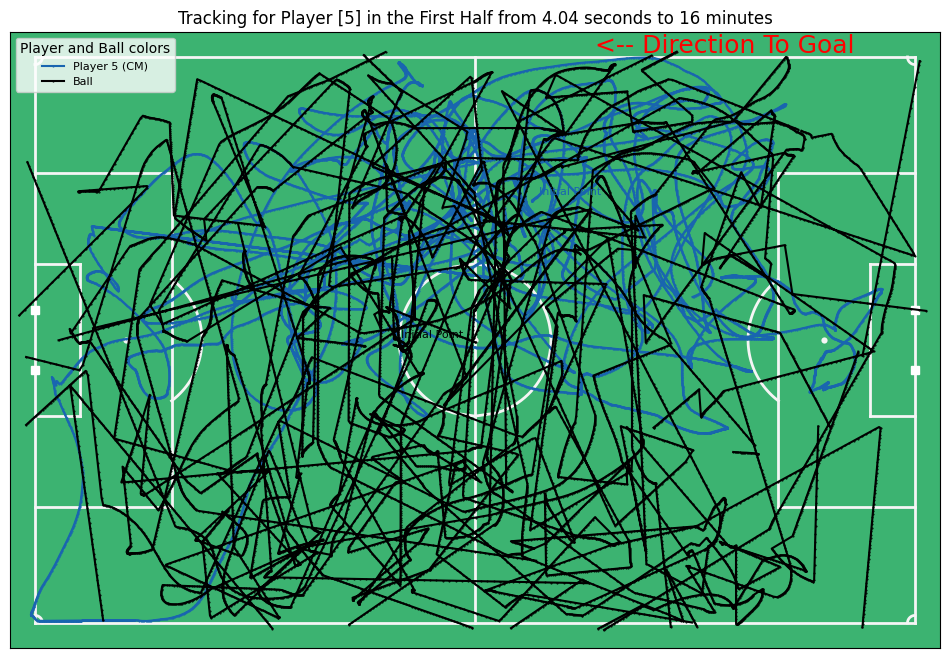

In [18]:
player_tracking(period_1_data, [5])

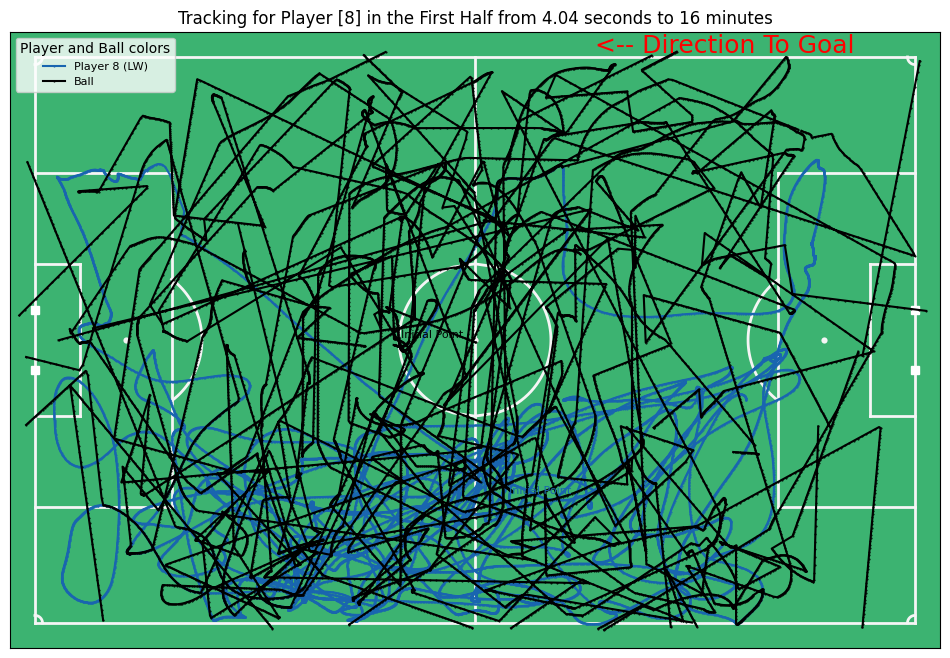

In [19]:
player_tracking(period_1_data, [8])

# Grouping players time interval on 1 second interval

In [20]:
df['Period'] = pd.to_numeric(df['Period'], errors='coerce')
period_1_data = df[df["Period"] == 1]
period_1_data = period_1_data[49:]

In [21]:
period_1_data

,Period,Frame,Time[s],P_1-x,P_1-y,P_2-x,P_2-y,P_3-x,P_3-y,P_4-x,...,P_8-x,P_8-y,P_9-x,P_9-y,P_10-x,P_10-y,P_11-x,P_11-y,ball-x,ball-y
49,1,50,2,0.64779,0.27056,0.67763,0.42627,0.68182,0.54645,0.64443,...,0.53309,0.78647,0.50151,0.35328,0.50054,0.65342,0.94802,0.48966,NaN,NaN
50,1,51,2.04,0.64787,0.27031,0.67763,0.42630,0.68143,0.54622,0.64436,...,0.53316,0.78648,0.5014,0.35295,0.50046,0.65322,0.94791,0.48986,0.50216,0.50376
51,1,52,2.08,0.64797,0.27005,0.67765,0.42629,0.68101,0.54602,0.64428,...,0.53323,0.78651,0.50128,0.35261,0.50036,0.65297,0.94779,0.49005,0.5004,0.50384
52,1,53,2.12,0.64805,0.26978,0.67767,0.42637,0.6806,0.54582,0.64418,...,0.53328,0.78657,0.50115,0.35226,0.50025,0.65270,0.94766,0.49025,0.4977,0.50397
53,1,54,2.16,0.64815,0.26943,0.67769,0.42634,0.6802,0.54562,0.64409,...,0.53334,0.78658,0.50102,0.35198,0.50011,0.65247,0.94756,0.49039,0.495,0.50410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67936,1,67937,2717.48,0.51337,0.71683,0.52318,0.78966,0.54702,0.86195,0.51242,...,0.40066,0.50905,0.35073,0.59980,0.337,0.79222,0.81546,0.72958,NaN,NaN
67937,1,67938,2717.52,0.51339,0.71801,0.52312,0.79035,0.54692,0.86271,0.51242,...,0.40095,0.50993,0.35105,0.60026,0.33727,0.79263,0.81461,0.73064,NaN,NaN
67938,1,67939,2717.56,0.5134,0.71929,0.52312,0.79124,0.54677,0.86355,0.51242,...,0.40122,0.51062,0.35136,0.60081,0.33756,0.79303,0.81413,0.73124,NaN,NaN
67939,1,67940,2717.6,0.51342,0.72035,0.52315,0.79171,0.54673,0.86423,0.51242,...,0.40148,0.51078,0.35166,0.60165,0.33781,0.79344,0.81385,0.73124,NaN,NaN


In [22]:
period_1_data = period_1_data.drop(columns=["Frame"])

In [23]:
period_1_data

,Period,Time[s],P_1-x,P_1-y,P_2-x,P_2-y,P_3-x,P_3-y,P_4-x,P_4-y,...,P_8-x,P_8-y,P_9-x,P_9-y,P_10-x,P_10-y,P_11-x,P_11-y,ball-x,ball-y
49,1,2,0.64779,0.27056,0.67763,0.42627,0.68182,0.54645,0.64443,0.77118,...,0.53309,0.78647,0.50151,0.35328,0.50054,0.65342,0.94802,0.48966,NaN,NaN
50,1,2.04,0.64787,0.27031,0.67763,0.42630,0.68143,0.54622,0.64436,0.77154,...,0.53316,0.78648,0.5014,0.35295,0.50046,0.65322,0.94791,0.48986,0.50216,0.50376
51,1,2.08,0.64797,0.27005,0.67765,0.42629,0.68101,0.54602,0.64428,0.77197,...,0.53323,0.78651,0.50128,0.35261,0.50036,0.65297,0.94779,0.49005,0.5004,0.50384
52,1,2.12,0.64805,0.26978,0.67767,0.42637,0.6806,0.54582,0.64418,0.77242,...,0.53328,0.78657,0.50115,0.35226,0.50025,0.65270,0.94766,0.49025,0.4977,0.50397
53,1,2.16,0.64815,0.26943,0.67769,0.42634,0.6802,0.54562,0.64409,0.77287,...,0.53334,0.78658,0.50102,0.35198,0.50011,0.65247,0.94756,0.49039,0.495,0.50410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67936,1,2717.48,0.51337,0.71683,0.52318,0.78966,0.54702,0.86195,0.51242,0.77079,...,0.40066,0.50905,0.35073,0.59980,0.337,0.79222,0.81546,0.72958,NaN,NaN
67937,1,2717.52,0.51339,0.71801,0.52312,0.79035,0.54692,0.86271,0.51242,0.77079,...,0.40095,0.50993,0.35105,0.60026,0.33727,0.79263,0.81461,0.73064,NaN,NaN
67938,1,2717.56,0.5134,0.71929,0.52312,0.79124,0.54677,0.86355,0.51242,0.77079,...,0.40122,0.51062,0.35136,0.60081,0.33756,0.79303,0.81413,0.73124,NaN,NaN
67939,1,2717.6,0.51342,0.72035,0.52315,0.79171,0.54673,0.86423,0.51242,0.77079,...,0.40148,0.51078,0.35166,0.60165,0.33781,0.79344,0.81385,0.73124,NaN,NaN


In [24]:
# Convert all columns to numeric
for col in period_1_data.columns:
    if col != "Period" and col != "Time[s]":
        period_1_data[col] = pd.to_numeric(period_1_data[col], errors='coerce')
    else:
        period_1_data[col] = pd.to_numeric(period_1_data[col], errors='coerce').astype(int)

avg_1_sec = pd.DataFrame()

# Calculate averages for each column
for col in period_1_data.columns:
    averages = []
    for i in range(0, len(period_1_data), 25):
        group = period_1_data[col].iloc[i:i+25]
        avg = group.mean()
        averages.append(avg)
    
    # Add the averages for this column to avg_1_sec
    avg_1_sec[col] = averages   

# avg_1_sec.reset_index(drop=True, inplace=True)
avg_1_sec.index = range(1, len(avg_1_sec) + 1)

In [25]:
avg_1_sec = avg_1_sec.iloc[:30]
avg_1_sec.head()

,Period,Time[s],P_1-x,P_1-y,P_2-x,P_2-y,P_3-x,P_3-y,P_4-x,P_4-y,...,P_8-x,P_8-y,P_9-x,P_9-y,P_10-x,P_10-y,P_11-x,P_11-y,ball-x,ball-y
1,1.0,2.0,0.648977,0.267991,0.677310,0.426190,0.676776,0.545300,0.643221,0.776967,...,0.533559,0.786388,0.499149,0.351891,0.497457,0.648717,0.946624,0.491144,0.472012,0.505173
2,1.0,3.0,0.650789,0.270286,0.675239,0.425550,0.665746,0.549138,0.641799,0.791332,...,0.532222,0.785681,0.489133,0.363388,0.481119,0.626600,0.942613,0.491384,0.414058,0.507987
3,1.0,4.0,0.651538,0.280022,0.676080,0.422136,0.657685,0.555499,0.645750,0.804490,...,0.530143,0.779241,0.479126,0.397800,0.458304,0.583250,0.934777,0.491824,0.412091,0.510291
4,1.0,5.0,0.661151,0.268981,0.682081,0.410478,0.656046,0.552907,0.655068,0.800052,...,0.533756,0.750292,0.484144,0.423878,0.441997,0.532778,0.925100,0.492292,0.422118,0.504578
5,1.0,6.0,0.673464,0.232932,0.684514,0.389209,0.654967,0.541258,0.663216,0.772410,...,0.538476,0.702497,0.494125,0.407635,0.432850,0.495466,0.914331,0.490325,0.432264,0.390942


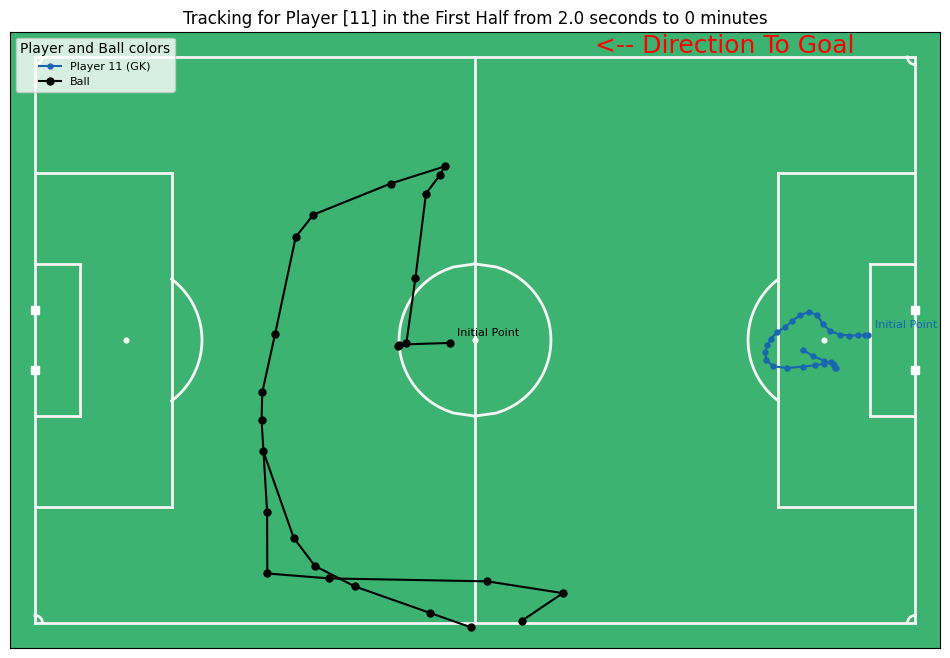

In [26]:
player_tracking(avg_1_sec, markersize=7)

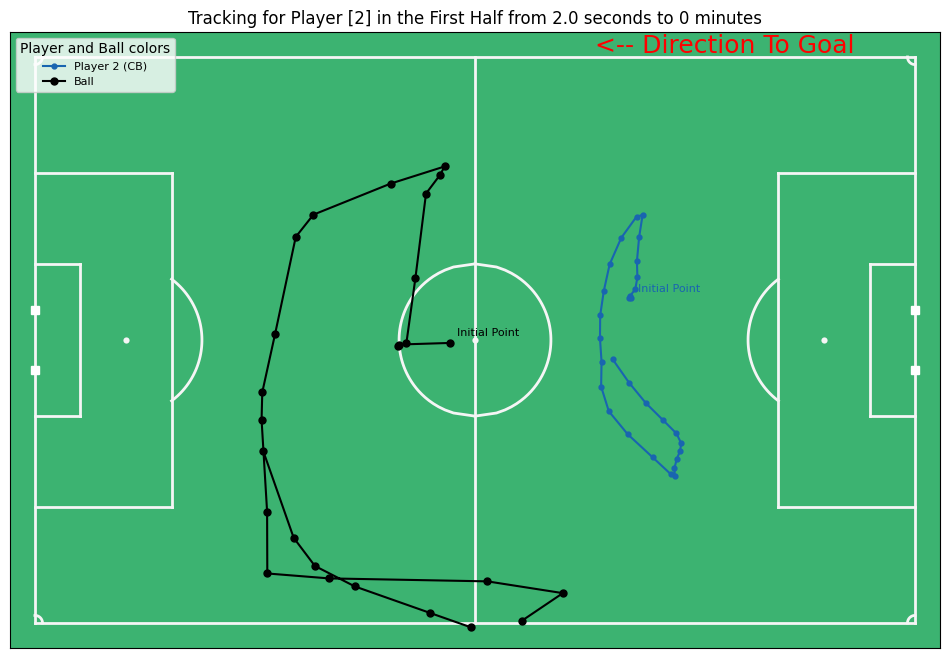

In [27]:
player_tracking(avg_1_sec, [2], markersize=7)

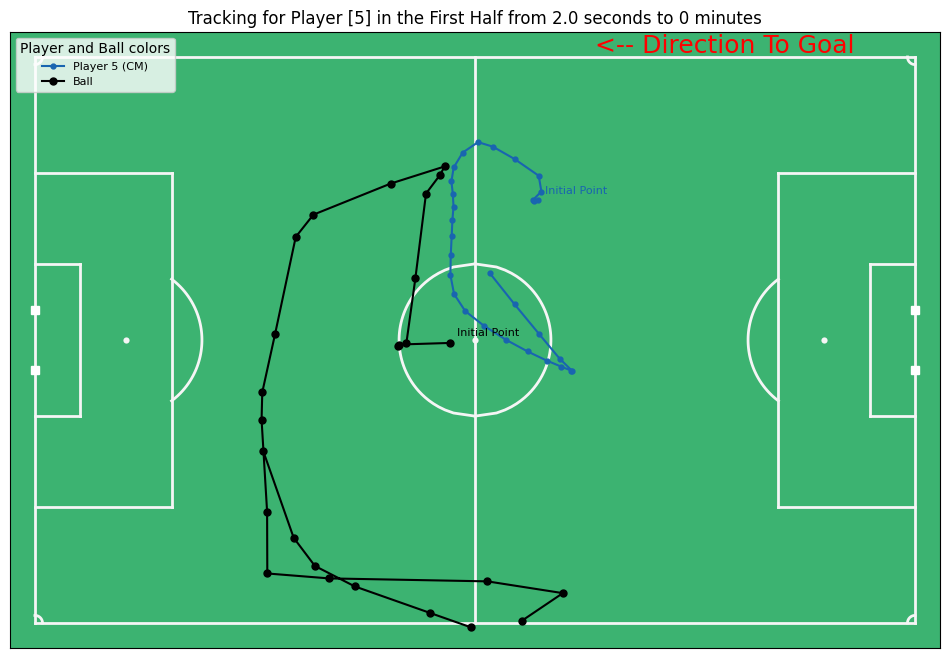

In [28]:
player_tracking(avg_1_sec, [5], markersize=7)

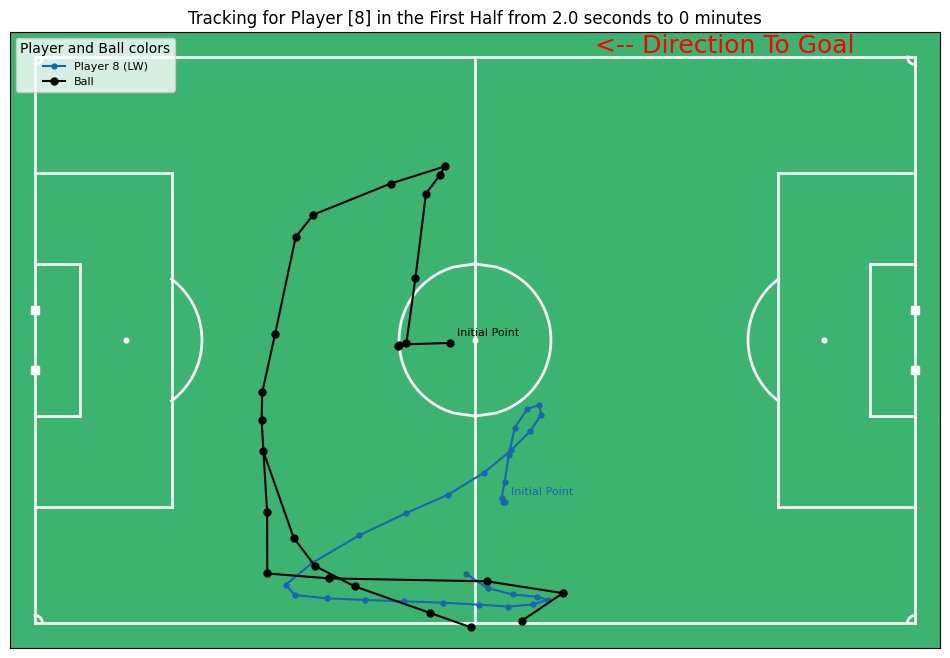

In [29]:
player_tracking(avg_1_sec, [8], markersize=7)

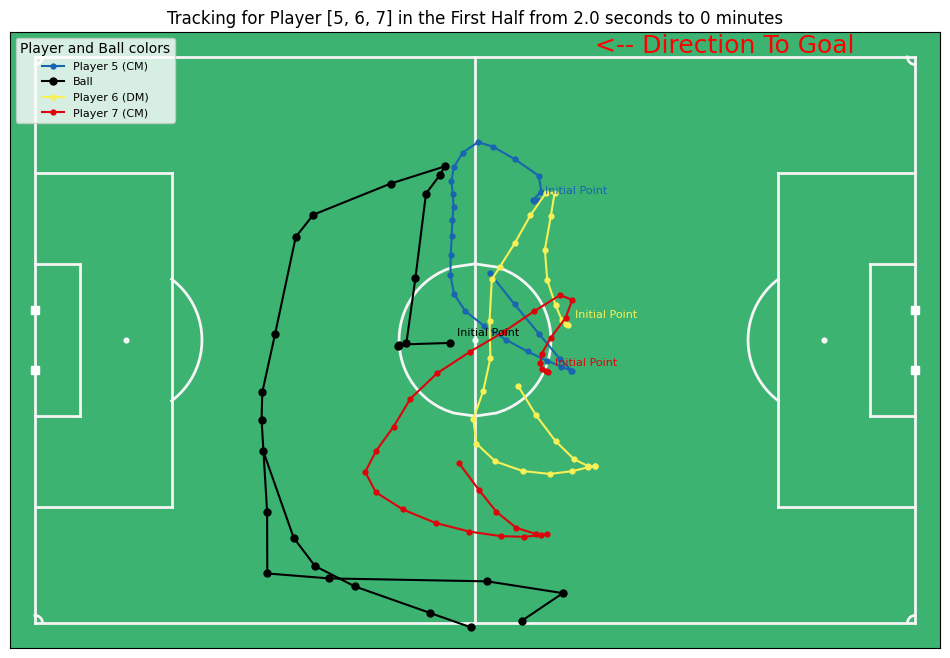

In [30]:
player_tracking(avg_1_sec, [5, 6, 7], markersize=7)

In [31]:
# Calculate players speed
def players_speed():
    MPS_TO_MPH = 2.23694
    player_columns = [(f'P_{i}-x', f'P_{i}-y') for i in range(1, 12)]
    
    for i, (x_col, y_col) in enumerate(player_columns, 1):
        # Calculate Euclidean distance between consecutive points
        x_diff = avg_1_sec[x_col].diff()
        y_diff = avg_1_sec[y_col].diff()
        distance = np.sqrt(x_diff**2 + y_diff**2)
        
        # Calculate time difference between frames
        time_diff = avg_1_sec['Time[s]'].diff()
        
        # Calculate speed (distance / time)
        # Note: First row will be NaN as we can't calculate speed for a single point
        speed = distance / time_diff
        speed_mph = speed * MPS_TO_MPH
        
        avg_1_sec[f"P_{i}_speed"] = speed_mph

players_speed()

In [32]:
avg_1_sec

,Period,Time[s],P_1-x,P_1-y,P_2-x,P_2-y,P_3-x,P_3-y,P_4-x,P_4-y,...,P_2_speed,P_3_speed,P_4_speed,P_5_speed,P_6_speed,P_7_speed,P_8_speed,P_9_speed,P_10_speed,P_11_speed
1,1.0,2.0,0.648977,0.267991,0.677310,0.426190,0.676776,0.545300,0.643221,0.776967,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,3.0,0.650789,0.270286,0.675239,0.425550,0.665746,0.549138,0.641799,0.791332,...,0.004850,0.026123,0.032289,0.010148,0.004511,0.009173,0.003383,0.034109,0.061508,0.008988
3,1.0,4.0,0.651538,0.280022,0.676080,0.422136,0.657685,0.555499,0.645750,0.804490,...,0.007865,0.022972,0.030733,0.005885,0.019720,0.012321,0.015137,0.080168,0.109582,0.017556
4,1.0,5.0,0.661151,0.268981,0.682081,0.410478,0.656046,0.552907,0.655068,0.800052,...,0.029329,0.006860,0.023087,0.038104,0.060523,0.021394,0.065260,0.059405,0.118649,0.021672
5,1.0,6.0,0.673464,0.232932,0.684514,0.389209,0.654967,0.541258,0.663216,0.772410,...,0.047888,0.026169,0.064464,0.062654,0.101537,0.038326,0.107435,0.042645,0.085938,0.024489
6,1.0,7.0,0.669840,0.190549,0.683956,0.360810,0.656676,0.524347,0.668404,0.733431,...,0.063539,0.038022,0.087961,0.089726,0.121056,0.068304,0.108067,0.111556,0.068995,0.027972
7,1.0,8.0,0.657696,0.153282,0.686473,0.318212,0.667702,0.505663,0.676364,0.695906,...,0.095455,0.048530,0.085810,0.074136,0.133020,0.086107,0.080455,0.115049,0.060652,0.033056
8,1.0,9.0,0.647824,0.136526,0.690394,0.279177,0.678354,0.489310,0.683986,0.674580,...,0.087759,0.043657,0.050659,0.041658,0.092825,0.073655,0.034305,0.070136,0.028013,0.037807
9,1.0,10.0,0.639936,0.143972,0.683520,0.282219,0.674642,0.489078,0.680512,0.687184,...,0.016817,0.008321,0.029245,0.056499,0.022093,0.036122,0.038365,0.045045,0.045032,0.024599
10,1.0,11.0,0.636148,0.160667,0.666208,0.319347,0.660450,0.502044,0.667983,0.723948,...,0.091638,0.043001,0.086883,0.063304,0.095794,0.092877,0.071537,0.077465,0.084859,0.027238


In [33]:
def clustering_dataset() -> np.array:
    cm_1 = np.array([avg_1_sec["P_5-x"], avg_1_sec["P_5-y"]])
    cm_2 = np.array([avg_1_sec["P_6-x"], avg_1_sec["P_6-y"]])
    cm_3 = np.array([avg_1_sec["P_7-x"], avg_1_sec["P_7-y"]])

    X = np.concatenate([cm_1, cm_2, cm_3], axis=1).T
    label = np.array([np.full(len(avg_1_sec["P_5-x"]), 0), np.full(len(avg_1_sec["P_6-x"]), 1), np.full(len(avg_1_sec["P_7-x"]), 2)])
    label = label.reshape(-1, 1)
    label = label.flatten()
    
    return X, label

In [34]:
X, y_true = clustering_dataset()

In [35]:
X.shape

(90, 2)

In [36]:
def clustering():
    kmeans = KMeans(n_clusters=3, random_state=0, init="random", n_init="auto").fit(X)
    kmeans_plus = KMeans(n_clusters=3, random_state=0, init="k-means++", n_init="auto").fit(X)
    b_kmeans = BisectingKMeans(n_clusters=3, random_state=0, init="random").fit(X)
    s_clustering = SpectralClustering(n_clusters=3).fit(X)
    single = AgglomerativeClustering(n_clusters=3, linkage="single").fit(X)
    complete = AgglomerativeClustering(n_clusters=3, linkage="complete").fit(X)
    average = AgglomerativeClustering(n_clusters=3, linkage="average").fit(X)
    ward = AgglomerativeClustering(n_clusters=3, linkage="ward").fit(X)

    return kmeans, kmeans_plus, b_kmeans, s_clustering, single, complete, average, ward

In [37]:
def accuracy():
    result = []
    clusters = clustering()
    for clus in clusters:
        result.append(clus)
        y_pred = clus.fit_predict(X)        
        acc = accuracy_score(y_true, y_pred)

        print(np.round(acc, 2))

accuracy()

0.48
0.23
0.22
0.14
0.34
0.3
0.16
0.3


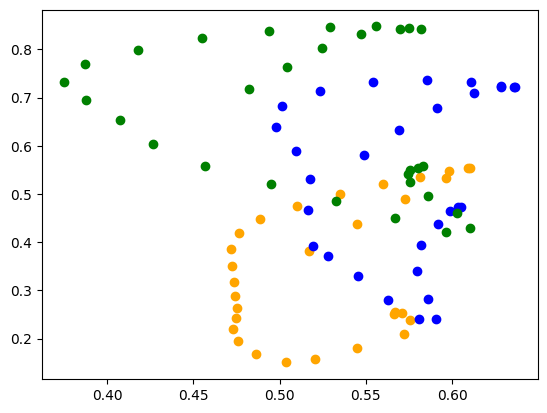

In [38]:
color = ["orange", "blue", "green"]
for i in range(90):
    if i < 30:
        plt.scatter(X[i][0], X[i][1], color="orange")
    elif i < 60 and i > 29:
        plt.scatter(X[i][0], X[i][1], color="blue")
    else:
        plt.scatter(X[i][0], X[i][1], color="green")
    plt.grid()
plt.show()

In [39]:
kmeans, kmeans_plus, b_kmeans, s_clustering, single_clu, complete_clu, average_clu, ward_clu = clustering()

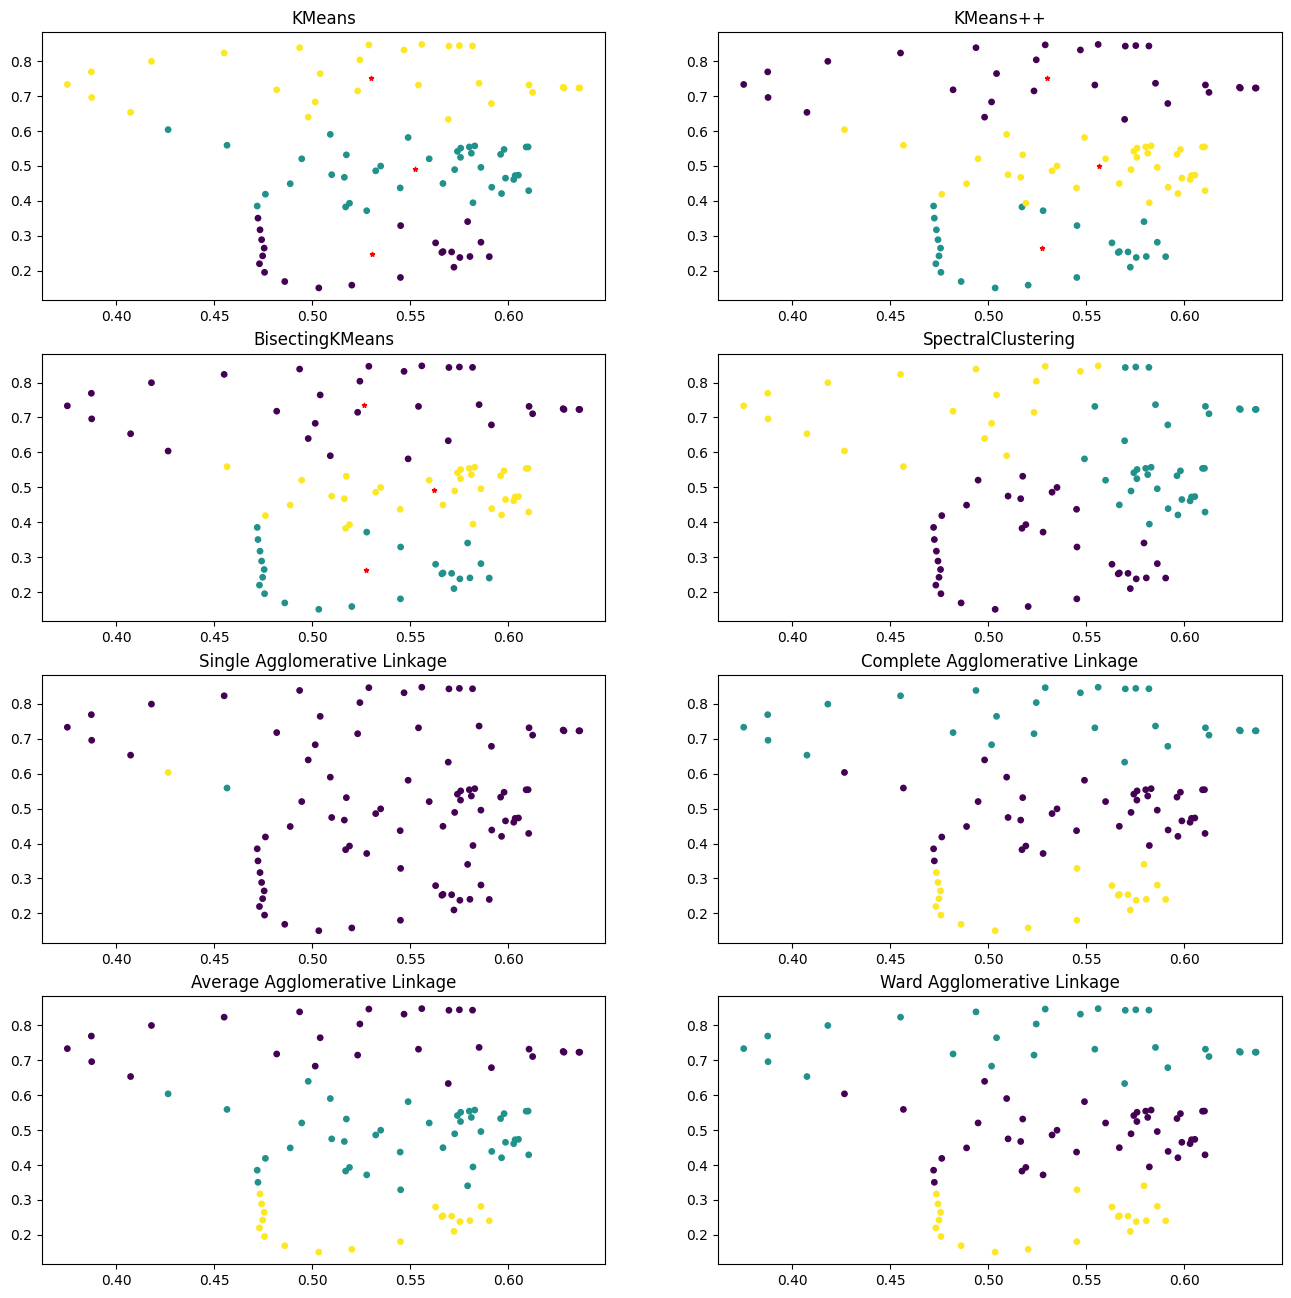

In [40]:
def plot_clusters():
    fig, ax = plt.subplots(4, 2, figsize=(16, 16))
    ax[0, 0].scatter(X[:, 0], X[:, 1], s=15, c=kmeans.labels_)
    ax[0, 0].scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=10, c="r", marker="*")
    ax[0, 0].set_title("KMeans")
    
    ax[0, 1].scatter(X[:, 0], X[:, 1], s=15, c=kmeans_plus.labels_)
    ax[0, 1].scatter(kmeans_plus.cluster_centers_[:, 0], kmeans_plus.cluster_centers_[:, 1], s=10, c="r", marker="*")
    ax[0, 1].set_title("KMeans++")
    
    ax[1, 0].scatter(X[:, 0], X[:, 1], s=15, c=b_kmeans.labels_)
    ax[1, 0].scatter(b_kmeans.cluster_centers_[:, 0], b_kmeans.cluster_centers_[:, 1], s=10, c="r", marker="*")
    ax[1, 0].set_title("BisectingKMeans")
    
    ax[1, 1].scatter(X[:, 0], X[:, 1], s=15, c=s_clustering.labels_)
    ax[1, 1].set_title("SpectralClustering")
    
    ax[2, 0].scatter(X[:, 0], X[:, 1], s=15, c=single_clu.labels_)
    ax[2, 0].set_title("Single Agglomerative Linkage")
    
    ax[2, 1].scatter(X[:, 0], X[:, 1], s=15, c=complete_clu.labels_)
    ax[2, 1].set_title("Complete Agglomerative Linkage")
    
    ax[3, 0].scatter(X[:, 0], X[:, 1], s=15, c=average_clu.labels_)
    ax[3, 0].set_title("Average Agglomerative Linkage")
    
    ax[3, 1].scatter(X[:, 0], X[:, 1], s=15, c=ward_clu.labels_)
    ax[3, 1].set_title("Ward Agglomerative Linkage")
    plt.show()
    
plot_clusters()

# Correlation Between Ball and Player

In [41]:
ball_player = avg_1_sec.loc[:, "P_1-x":"ball-y"]

In [42]:
ball_player

,P_1-x,P_1-y,P_2-x,P_2-y,P_3-x,P_3-y,P_4-x,P_4-y,P_5-x,P_5-y,...,P_8-x,P_8-y,P_9-x,P_9-y,P_10-x,P_10-y,P_11-x,P_11-y,ball-x,ball-y
1,0.648977,0.267991,0.677310,0.426190,0.676776,0.545300,0.643221,0.776967,0.571214,0.253519,...,0.533559,0.786388,0.499149,0.351891,0.497457,0.648717,0.946624,0.491144,0.472012,0.505173
2,0.650789,0.270286,0.675239,0.425550,0.665746,0.549138,0.641799,0.791332,0.566802,0.254574,...,0.532222,0.785681,0.489133,0.363388,0.481119,0.626600,0.942613,0.491384,0.414058,0.507987
3,0.651538,0.280022,0.676080,0.422136,0.657685,0.555499,0.645750,0.804490,0.566221,0.252008,...,0.530143,0.779241,0.479126,0.397800,0.458304,0.583250,0.934777,0.491824,0.412091,0.510291
4,0.661151,0.268981,0.682081,0.410478,0.656046,0.552907,0.655068,0.800052,0.575408,0.237664,...,0.533756,0.750292,0.484144,0.423878,0.441997,0.532778,0.925100,0.492292,0.422118,0.504578
5,0.673464,0.232932,0.684514,0.389209,0.654967,0.541258,0.663216,0.772410,0.572388,0.209819,...,0.538476,0.702497,0.494125,0.407635,0.432850,0.495466,0.914331,0.490325,0.432264,0.390942
6,0.669840,0.190549,0.683956,0.360810,0.656676,0.524347,0.668404,0.733431,0.545102,0.180419,...,0.545227,0.654660,0.496276,0.357812,0.436036,0.464787,0.903400,0.484251,0.444339,0.241323
7,0.657696,0.153282,0.686473,0.318212,0.667702,0.505663,0.676364,0.695906,0.520288,0.158450,...,0.559574,0.621679,0.496172,0.306380,0.449550,0.441281,0.895292,0.471897,0.459828,0.209286
8,0.647824,0.136526,0.690394,0.279177,0.678354,0.489310,0.683986,0.674580,0.503459,0.150475,...,0.573242,0.614725,0.489030,0.275851,0.461966,0.439646,0.888815,0.456286,0.465626,0.193352
9,0.639936,0.143972,0.683520,0.282219,0.674642,0.489078,0.680512,0.687184,0.486096,0.168819,...,0.575201,0.631764,0.468898,0.275405,0.460148,0.459695,0.879513,0.450421,0.404273,0.223610
10,0.636148,0.160667,0.666208,0.319347,0.660450,0.502044,0.667983,0.723948,0.475794,0.195176,...,0.562692,0.661195,0.444960,0.300429,0.445403,0.494648,0.868912,0.456411,0.316397,0.278592


In [43]:
player_pos = ["RB", "CB", "CB", "LB", "CM", "DM", "CM", "LW", "RW", "ST", "GK"]

x_ball_player = ball_player.loc[:, ball_player.columns.str.contains("x")]
y_ball_player = ball_player.loc[:, ball_player.columns.str.contains("y")]

x_ball_player.columns = (player_pos + [x_ball_player.columns[-1]])
y_ball_player.columns = (player_pos + [y_ball_player.columns[-1]])

In [44]:
x_ball_player

,RB,CB,CB,LB,CM,DM,CM,LW,RW,ST,GK,ball-x
1,0.648977,0.677310,0.676776,0.643221,0.571214,0.605284,0.583005,0.533559,0.499149,0.497457,0.946624,0.472012
2,0.650789,0.675239,0.665746,0.641799,0.566802,0.603600,0.580232,0.532222,0.489133,0.481119,0.942613,0.414058
3,0.651538,0.676080,0.657685,0.645750,0.566221,0.598681,0.575831,0.530143,0.479126,0.458304,0.934777,0.412091
4,0.661151,0.682081,0.656046,0.655068,0.575408,0.591668,0.574166,0.533756,0.484144,0.441997,0.925100,0.422118
5,0.673464,0.684514,0.654967,0.663216,0.572388,0.582097,0.575735,0.538476,0.494125,0.432850,0.914331,0.432264
6,0.669840,0.683956,0.656676,0.668404,0.545102,0.579369,0.586136,0.545227,0.496276,0.436036,0.903400,0.444339
7,0.657696,0.686473,0.667702,0.676364,0.520288,0.586158,0.602883,0.559574,0.496172,0.449550,0.895292,0.459828
8,0.647824,0.690394,0.678354,0.683986,0.503459,0.590410,0.610504,0.573242,0.489030,0.461966,0.888815,0.465626
9,0.639936,0.683520,0.674642,0.680512,0.486096,0.580543,0.596671,0.575201,0.468898,0.460148,0.879513,0.404273
10,0.636148,0.666208,0.660450,0.667983,0.475794,0.563034,0.566784,0.562692,0.444960,0.445403,0.868912,0.316397


In [45]:
y_ball_player

,RB,CB,CB,LB,CM,DM,CM,LW,RW,ST,GK,ball-y
1,0.267991,0.426190,0.545300,0.776967,0.253519,0.473360,0.557250,0.786388,0.351891,0.648717,0.491144,0.505173
2,0.270286,0.425550,0.549138,0.791332,0.254574,0.472251,0.554229,0.785681,0.363388,0.626600,0.491384,0.507987
3,0.280022,0.422136,0.555499,0.804490,0.252008,0.464935,0.550917,0.779241,0.397800,0.583250,0.491824,0.510291
4,0.268981,0.410478,0.552907,0.800052,0.237664,0.438804,0.541499,0.750292,0.423878,0.532778,0.492292,0.504578
5,0.232932,0.389209,0.541258,0.772410,0.209819,0.394433,0.524438,0.702497,0.407635,0.495466,0.490325,0.390942
6,0.190549,0.360810,0.524347,0.733431,0.180419,0.340385,0.495729,0.654660,0.357812,0.464787,0.484251,0.241323
7,0.153282,0.318212,0.505663,0.695906,0.158450,0.281309,0.461070,0.621679,0.306380,0.441281,0.471897,0.209286
8,0.136526,0.279177,0.489310,0.674580,0.150475,0.240031,0.429037,0.614725,0.275851,0.439646,0.456286,0.193352
9,0.143972,0.282219,0.489078,0.687184,0.168819,0.240453,0.420707,0.631764,0.275405,0.459695,0.450421,0.223610
10,0.160667,0.319347,0.502044,0.723948,0.195176,0.279534,0.449528,0.661195,0.300429,0.494648,0.456411,0.278592


## X-coordinates correlation

In [46]:
x_ball_player.corr()#.iloc[-1]

,RB,CB,CB,LB,CM,DM,CM,LW,RW,ST,GK,ball-x
RB,1.000000,0.825171,0.868260,0.657454,0.875913,0.842915,0.513422,0.507215,0.531903,0.459705,0.582149,0.248017
CB,0.825171,1.000000,0.856738,0.507811,0.722184,0.767798,0.436216,0.282281,0.371637,0.328532,0.542373,0.742217
CB,0.868260,0.856738,1.000000,0.774763,0.763797,0.925261,0.702427,0.622221,0.612393,0.613589,0.673618,0.382780
LB,0.657454,0.507811,0.774763,1.000000,0.648365,0.833330,0.908738,0.954587,0.825338,0.874917,0.710192,0.116480
CM,0.875913,0.722184,0.763797,0.648365,1.000000,0.896694,0.627034,0.562683,0.703201,0.632978,0.855369,0.349543
DM,0.842915,0.767798,0.925261,0.833330,0.896694,1.000000,0.840239,0.748380,0.814446,0.796318,0.876255,0.370464
CM,0.513422,0.436216,0.702427,0.908738,0.627034,0.840239,1.000000,0.927983,0.950377,0.957082,0.829831,0.273551
LW,0.507215,0.282281,0.622221,0.954587,0.562683,0.748380,0.927983,1.000000,0.887147,0.939561,0.697853,0.005006
RW,0.531903,0.371637,0.612393,0.825338,0.703201,0.814446,0.950377,0.887147,1.000000,0.952208,0.862473,0.277504
ST,0.459705,0.328532,0.613589,0.874917,0.632978,0.796318,0.957082,0.939561,0.952208,1.000000,0.844160,0.198508


## Y-coordinates correlation

In [47]:
y_ball_player.corr()#.iloc[-1]

,RB,CB,CB,LB,CM,DM,CM,LW,RW,ST,GK,ball-y
RB,1.000000,0.881631,0.844947,0.849909,0.967364,0.932867,0.944843,0.917228,0.960126,0.931788,0.915229,0.883411
CB,0.881631,1.000000,0.982490,0.982468,0.953096,0.981535,0.980817,0.970488,0.940450,0.964832,0.974429,0.980041
CB,0.844947,0.982490,1.000000,0.952150,0.940418,0.956692,0.969212,0.944531,0.914858,0.938122,0.954057,0.940194
LB,0.849909,0.982468,0.952150,1.000000,0.924717,0.956762,0.952109,0.956270,0.929689,0.936495,0.942207,0.970012
CM,0.967364,0.953096,0.940418,0.924717,1.000000,0.964001,0.986459,0.955715,0.970699,0.968248,0.946515,0.938396
DM,0.932867,0.981535,0.956692,0.956762,0.964001,1.000000,0.988673,0.987373,0.960434,0.983512,0.988474,0.971451
CM,0.944843,0.980817,0.969212,0.952109,0.986459,0.988673,1.000000,0.979902,0.977161,0.979810,0.980974,0.967376
LW,0.917228,0.970488,0.944531,0.956270,0.955715,0.987373,0.979902,1.000000,0.956924,0.990117,0.970267,0.982110
RW,0.960126,0.940450,0.914858,0.929689,0.970699,0.960434,0.977161,0.956924,1.000000,0.943743,0.960936,0.941956
ST,0.931788,0.964832,0.938122,0.936495,0.968248,0.983512,0.979810,0.990117,0.943743,1.000000,0.960139,0.972206
